<a href="https://colab.research.google.com/github/ReginaMT/ReginaMT/blob/main/redshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df_spectra = pd.read_csv('/content/balanced_spectra_features.csv')
print("CSV columns:", df_spectra.columns.tolist())
print(df_spectra.tail())


CSV columns: ['targetid', 'survey', 'program', 'desi_target', 'z', 'zwarn', 'spectype', 'desiname', 'specid', 'redshift']
              targetid survey program          desi_target         z  zwarn  \
487  39628031613995781   main    dark  4611686018427650052  1.132489      0   
488  39627689362983081   main    dark  4611686018428829830  0.870082      0   
489  39627474228742564   main    dark  4611686018428829830  1.057718      0   
490  39627812356756299   main    dark  4611686018427650052  1.293974      0   
491  39627869730643820   main    dark  6917529027641344004  0.777878      0   

    spectype                desiname        specid  redshift  
487   GALAXY  DESI J020.5016+10.2330  3.962803e+16  1.132489  
488   GALAXY  DESI J073.9506-03.9645  3.962769e+16  0.870082  
489   GALAXY  DESI J065.4778-12.9870  3.962747e+16  1.057718  
490      QSO  DESI J206.9822+01.0158  3.962781e+16  1.293974  
491      QSO  DESI J027.2577+03.5412  3.962787e+16  0.777878  


In [4]:
filepath = '/content/balanced_spectra_flux.npz'
data = np.load(filepath, allow_pickle=True)

targetids   = data['targetids']
flux_arrays = data['flux_arrays']


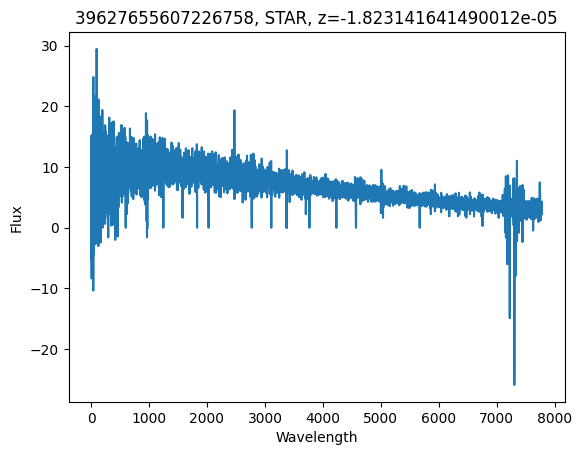

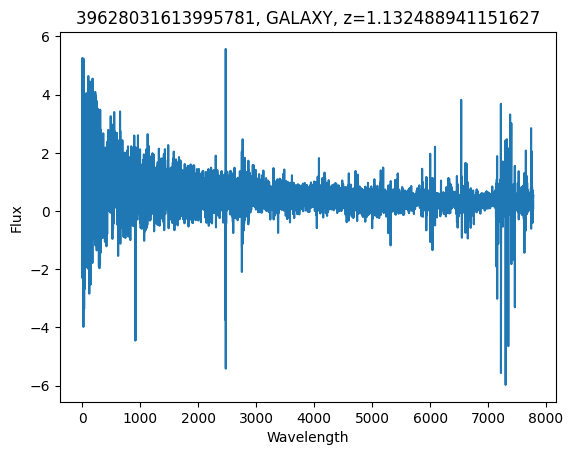

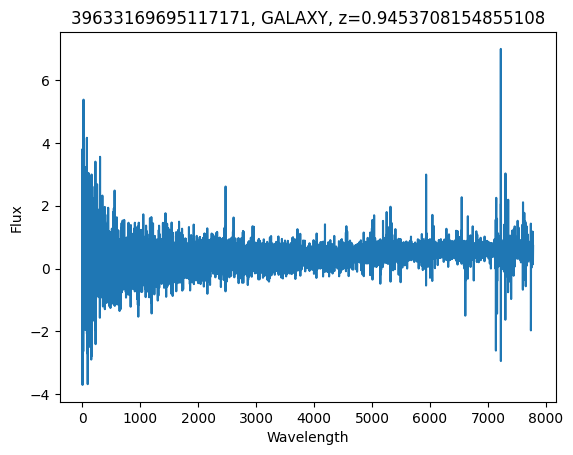

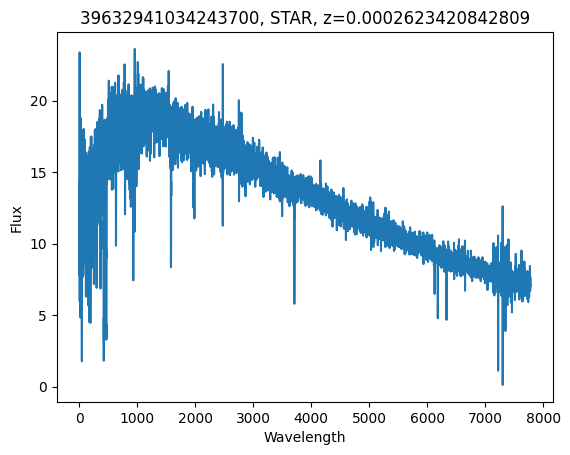

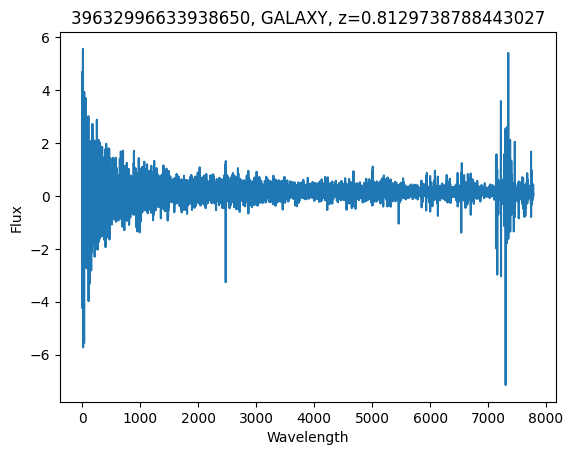

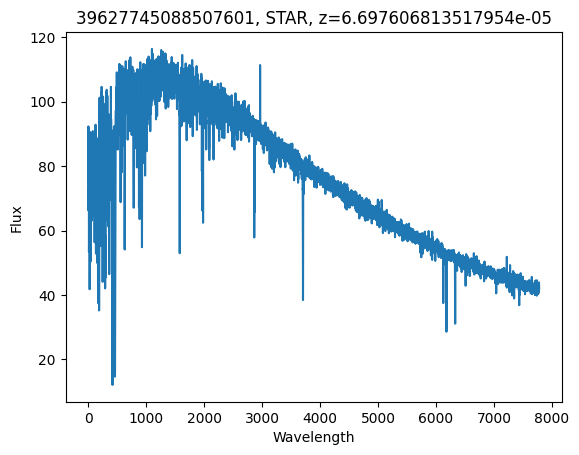

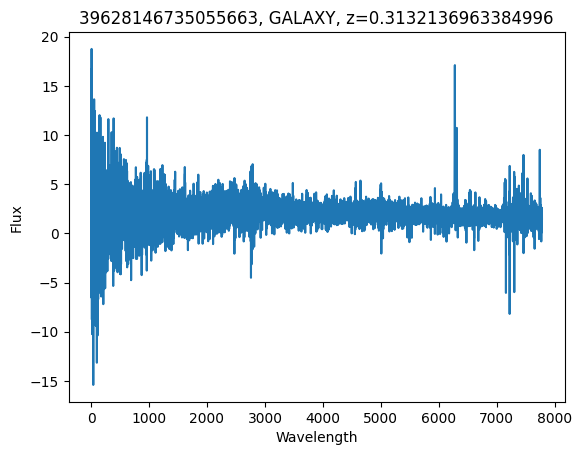

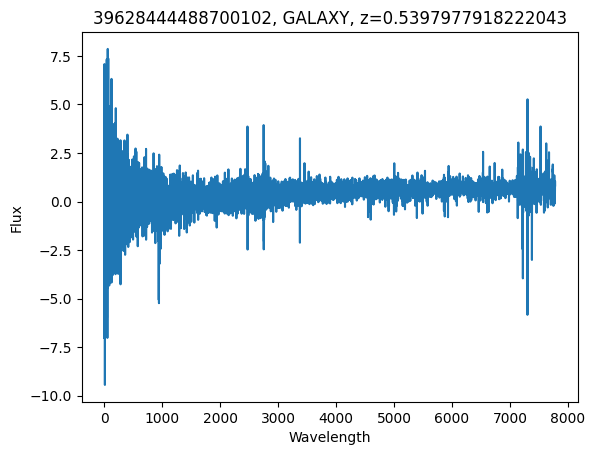

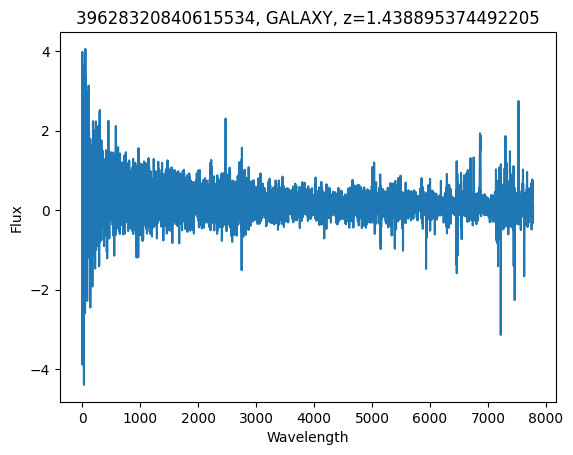

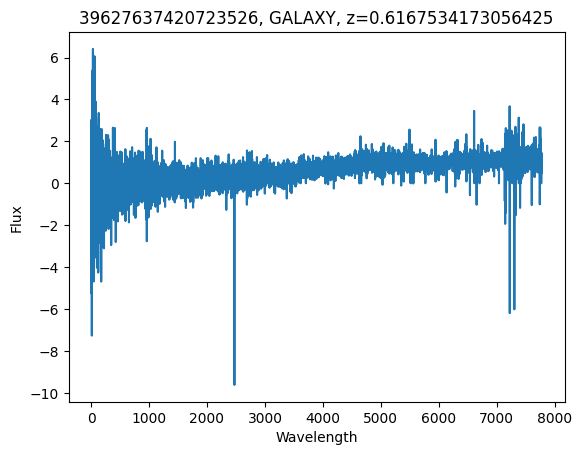

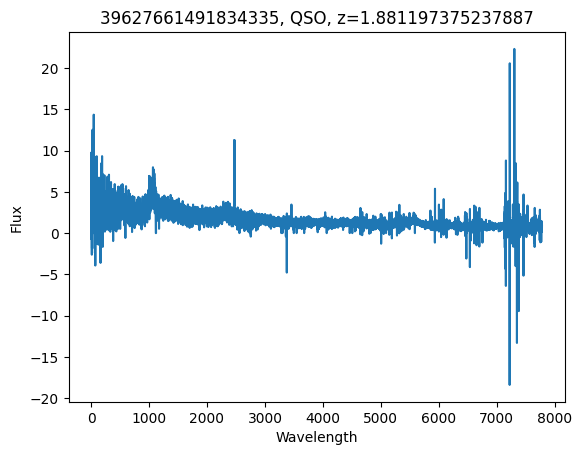

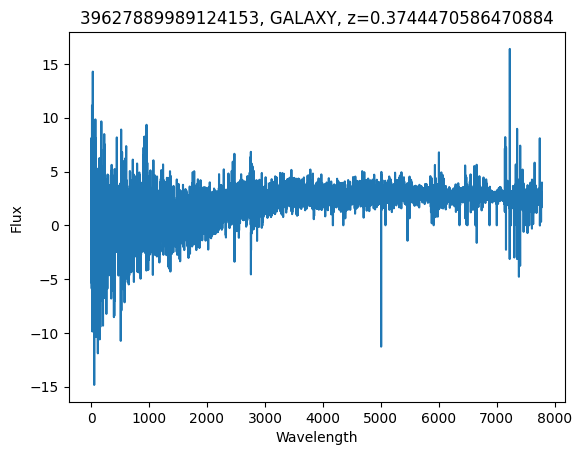

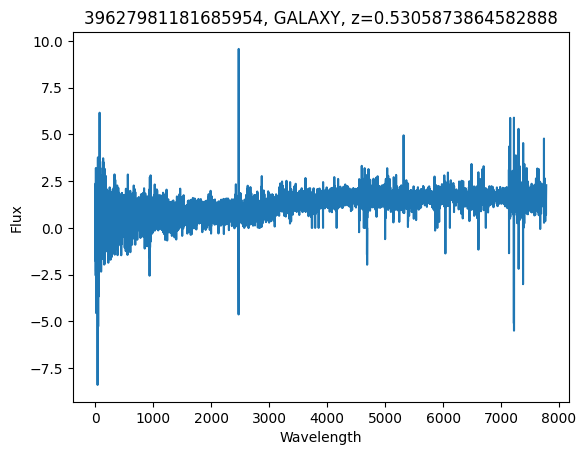

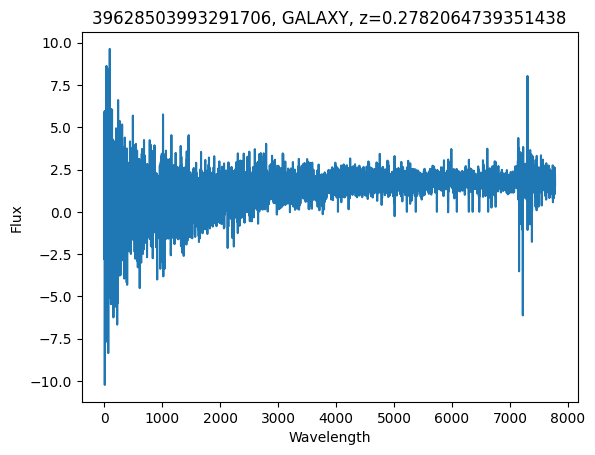

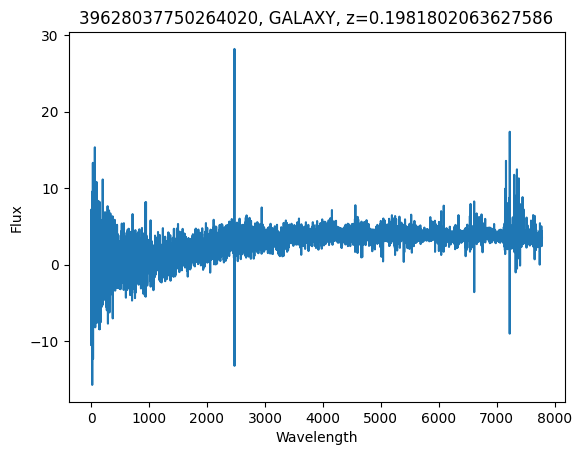

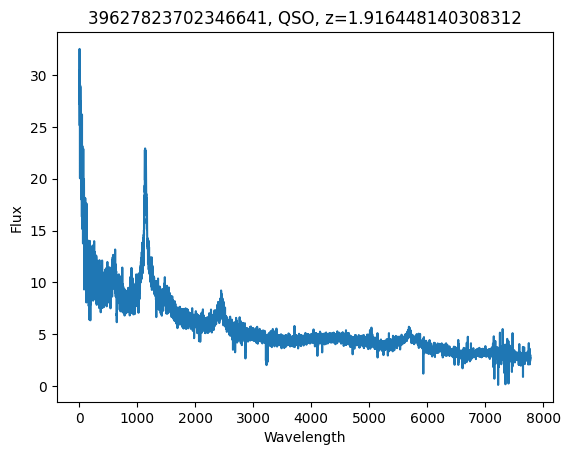

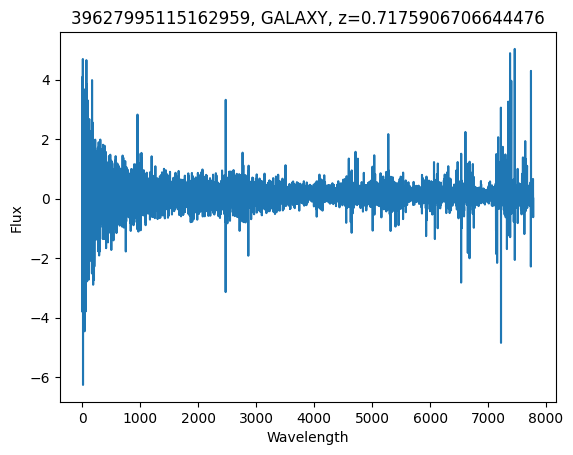

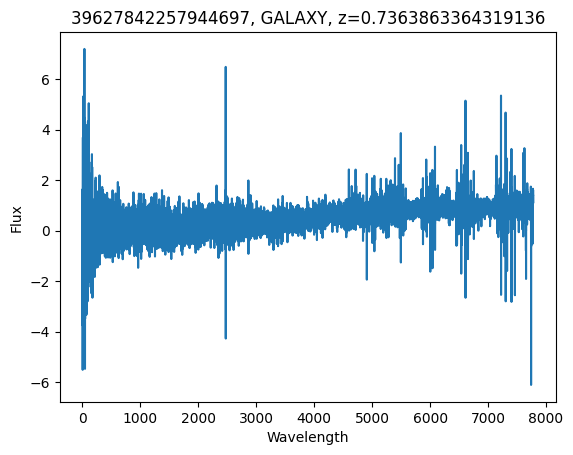

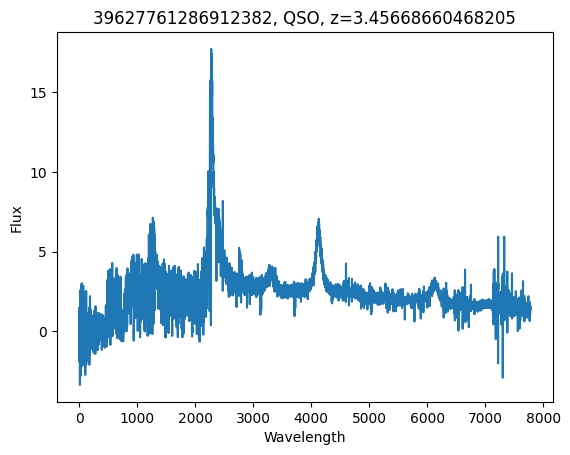

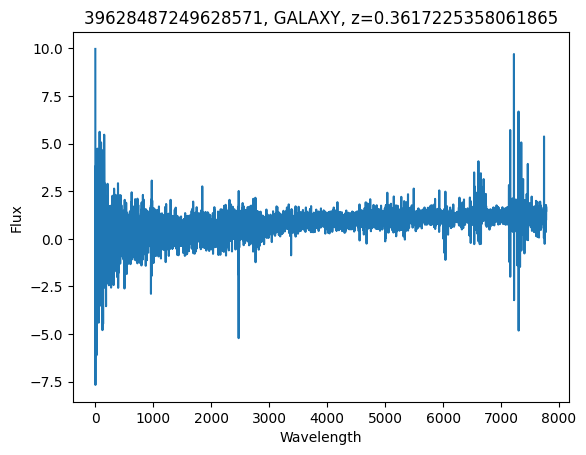

In [5]:
for i in range(20):
    spectype = df_spectra.loc[df_spectra['targetid'] == targetids[i], 'spectype'].values[0]
    redshift = df_spectra.loc[df_spectra['targetid'] == targetids[i], 'z'].values[0]

    plt.plot(flux_arrays[i])
    plt.title(f'{targetids[i]}, {spectype}, z={redshift}')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.show()


In [6]:
df_indexed = df_spectra.set_index('targetid')

df_aligned = df_indexed.loc[targetids]

mask_galaxy = df_aligned['spectype'] == 'GALAXY'

Y = df_aligned.loc[mask_galaxy, 'z'].to_numpy()
X = flux_arrays[mask_galaxy].astype('float32')
print("Shape X:", X.shape)
print("Shape Y:", Y.shape)


Shape X: (326, 7781)
Shape Y: (326,)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=112
)

print("X_train shape:", X_train.shape)

original_shape = X_train.shape[1:]
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

X_train = X_train_scaled.reshape(X_train.shape[0], *original_shape)
X_test  = X_test_scaled.reshape(X_test.shape[0], *original_shape)

print("X_train shape (after scaling):", X_train.shape)


X_train shape: (228, 7781)
X_train shape (after scaling): (228, 7781)


In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

model = MLPRegressor(
    hidden_layer_sizes=(200, 120, 70, 20),
    random_state=42,
    max_iter=1000
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n" + "="*60)
print("REGRESSION MODEL COMPARISON SUMMARY")
print("="*60)
print(f"R2 = {r2:.4f}, MSE = {mse:.4f}, MAE = {mae:.4f}")



REGRESSION MODEL COMPARISON SUMMARY
R2 = -1.3037, MSE = 0.3359, MAE = 0.3375


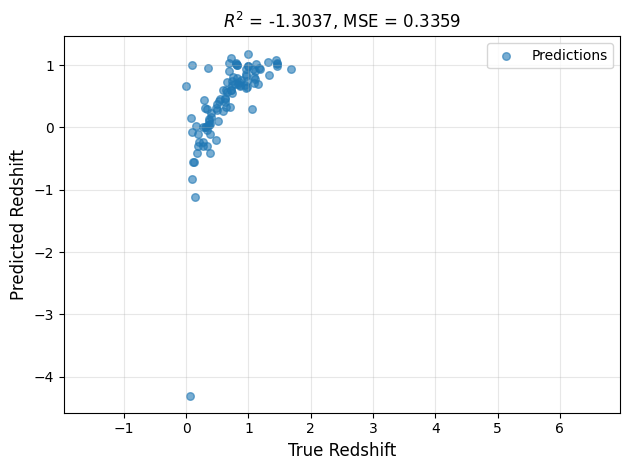

In [10]:
fig, axes = plt.subplots(1, 1)

axes.scatter(y_test, y_pred, alpha=0.6, s=30, label='Predictions')

min_val = 0
max_val = 5
axes.set_xlabel('True Redshift', fontsize=12)
axes.set_ylabel('Predicted Redshift', fontsize=12)
axes.set_title(f'$R^2$ = {r2:.4f}, MSE = {mse:.4f}', fontsize=12)
axes.legend()
axes.grid(True, alpha=0.3)
axes.axis('equal')
plt.xlim(min_val, max_val)
plt.tight_layout()
plt.show()


(0.0, 2.0)

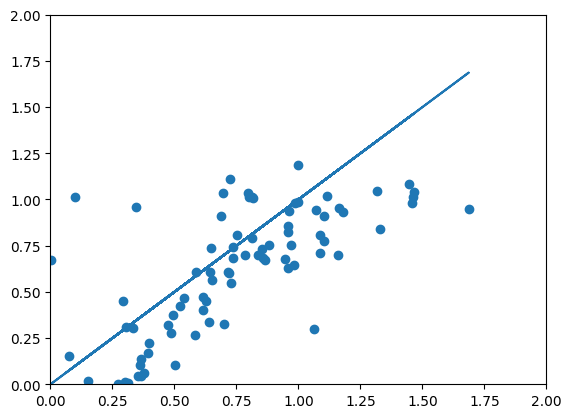

In [11]:
plt.scatter(y_test,y_pred)
plt.plot(y_test,y_test)
plt.xlim(0,2)
plt.ylim(0,2)